## 1. 多层感知机
线性模型可能会出错。前面pytorch2里搭建的softmax回归的模型架构通过单个仿射变换将我们的输入直接映射到输出，然后进行softmax操作。

如果我们的标签通过仿射变换后确实与我们的输入数据相关，那么这种方法确实足够了。 

但是，仿射变换中的线性是一个？！强强！？的假设，哪有那么好的事呢，所以在网络中加入一个或多个隐藏层来克服线性模型的限制，将许多全连接层堆叠在一起

也就是说，把前L-1层看作表示，最后一层看作线性预测器，这样的架构称为多层感知机（MultiLayer Perception）
![](/img/pytorch/hidden-layer.png)
隐藏层：h = Wx + b  (线性变换)
输出层：y = Vh + c   (线性变换)
整体：y = V(Wx + b) + c = (VW)x + (Vb + c)  ← 这还是线性！
但是，我们可以在隐藏层中引入非线性变换，例如ReLU函数，将其引入到隐藏层中，从而引入非线性。
### 1.1 激活函数
激活函数（activation function）通过计算加权和并加上偏置来确定神经元是否应该被激活， 它们将输入信号转换为输出的可微运算。 大多数激活函数都是非线性的

隐藏层：h' = φ(Wx + b)  (非线性变换！)
输出层：y = Vh' + c
整体：非线性！无法简化为一个线性公式
#### 1.1.1 ReLU
修正线性单元（Rectified linear unit，ReLU），给定元素x，ReLU定义为该元素和0的较大值
$$
\text{ReLU}(x) = \max(x, 0).
$$
![](/img/dl/relu.png)
#### 1.1.2 Sigmoid
对于一个定义域在$(-\infty, \infty)$中的输入， sigmoid函数将输入变换为区间(0, 1)上的输出。 因此，sigmoid通常称为挤压函数（squashing function）： 它将范围（-inf, inf）中的任意输入压缩到区间（0, 1）中的某个值：
$$
\text{sigmoid}(x) = \frac{1}{1 + \exp(-x)}.
$$
![](/img/dl/sigmoid.png)
#### 1.1.3 tanh
与sigmoid函数类似， tanh(双曲正切)函数也能将其输入压缩转换到区间(-1, 1)上
> 函数的形状类似于sigmoid函数， 不同的是tanh函数关于坐标系原点中心对称。
$$
\text{tanh}(x) = \frac{1 - \exp(-2x)}{1 + \exp(-2x)}.
$$
![](/img/dl/tanh.png)
其导数为$\frac{d}{dx} \text{tanh}(x) = 1 - \text{tanh}^2(x).$
### 1.2 实现MLP
> 直接套用pytorch2里搭建的softmax回归的模型架构，只是在中间加入一个隐藏层，隐藏层的输出通过激活函数进行变换，还有Pytorch的API。

In [11]:
import torch
from torch import nn
import os
import json
import types
import torchvision
from torchvision import transforms
from torch.utils import data

def load_data_fashion_mnist(batch_size, resize=None):
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)

    mnist_train = torchvision.datasets.FashionMNIST(
        root="../pytorch-02/data", train=True, transform=trans, download=True
    )
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../pytorch-02/data", train=False, transform=trans, download=True
    )

    train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=0)
    test_iter = data.DataLoader(mnist_test, batch_size, shuffle=False, num_workers=0)
    return train_iter, test_iter

# 定义网络结构
net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)

# 初始化权重
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
net.apply(init_weights)

# 超参数设置
batch_size, lr, num_epochs = 256, 0.01, 10
loss = nn.CrossEntropyLoss()
trainer = torch.optim.SGD(net.parameters(), lr=lr)

train_iter, test_iter = load_data_fashion_mnist(batch_size)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device)
for epoch in range(num_epochs):
    # 训练阶段
    net.train()
    total_loss = 0.0
    for X, y in train_iter:
        X, y = X.to(device), y.to(device)
        l = loss(net(X), y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
        total_loss += l.item()
    
    # 测试阶段（用上test_iter计算准确率）
    net.eval()  # 切换到评估模式
    correct, total = 0, 0
    with torch.no_grad():  # 禁用梯度，加速测试
        for X, y in test_iter:
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            correct += (y_hat.argmax(dim=1) == y).sum().item()
            total += y.numel()
    test_acc = correct / total
    
    # 打印训练损失+测试准确率
    print(f"epoch {epoch+1}, loss {total_loss/len(train_iter):.6f}, test acc {test_acc:.4f}")


epoch 1, loss 2.147069, test acc 0.4677
epoch 2, loss 1.511331, test acc 0.6163
epoch 3, loss 1.109031, test acc 0.6511
epoch 4, loss 0.926872, test acc 0.6672
epoch 5, loss 0.831965, test acc 0.6919
epoch 6, loss 0.772778, test acc 0.7109
epoch 7, loss 0.729531, test acc 0.7387
epoch 8, loss 0.694974, test acc 0.7521
epoch 9, loss 0.665357, test acc 0.7628
epoch 10, loss 0.640670, test acc 0.7761


## 2. 过拟合与欠拟合
字面意思。。
- 训练误差（training error）： 模型在训练数据集上计算得到的误差。 
- 泛化误差（generalization error）：模型应用在同样从原始样本的分布中抽取的无限多数据样本时，模型误差的期望
欠拟合（underfitting）：训练误差和验证误差都很严重， 但它们之间仅有一点差距。 如果模型不能降低训练误差，这可能意味着模型过于简单（即表达能力不足）， 无法捕获试图学习的模式。 此外，由于我们的训练和验证误差之间的泛化误差很小， 我们有理由相信可以用一个更复杂的模型降低训练误差。

过拟合（overfitting）：训练误差明显低于验证误差

### 2.1 影响因素
主要是**模型复杂性**与**数据集大小**。
![](/img/pytorch/overfitting.png)
### 2.2 验证
#### 2.2.1 验证集
验证集（validation set）：用于模型选择。 它是从原始样本中独立抽取的一个数据集， 用于评估模型在未见过的数据上的性能。

所有数据 = 训练集(70%) + 验证集(15%) + 测试集(15%)

- 训练集：用于训练模型（课本）
- 验证集：用于调整模型超参数（月考）
- 测试集：最终评估模型（高考）→ 最终模型训完之后再用只用一次！
而训练和验证每个epoch都用一遍。
#### 2.2.2 K折交叉验证（K-fold cross-validation）
当数据很少时，可以把原始训练数据分为 K 个互斥的子集， 称为折叠（fold）。 
然后执行 K 次训练和验证， 每次在 K-1 个折叠上训练模型， 并在剩余的一个折叠上验证模型。 
最后，我们取 K 次验证误差的平均值作为模型在验证集上的性能。
#### 2.2.3 多项式回归

### 2.3 正则化与权重衰减
权重衰减是解决过拟合的常用方法之一，本质是通过L2正则化降低模型复杂度。正则化的核心思想是在损失函数中添加**正则项**，用于惩罚模型的复杂度。

比如说对于线性回归：
$$L(w, b) = \frac{1}{n} \cdot \sum_{i=1}^{n}(y_i - (w \cdot x_i + b))^2$$
加入L2正则化后
$$L_{reg}(w, b) = \frac{1}{n} \cdot \sum_{i=1}^{n}(y_i - (w \cdot x_i + b))^2 + \frac{λ}{2} \cdot ||w||^2$$
其中：
- $||w||^2 = w_1^2 + w_2^2 + ... + w_d^2$：权重的L2范数平方
- $\lambda$：正则化强度超参数（$\lambda$越大，正则化约束越强）
- 通常仅正则化权重$w$，不正则化偏置$b$（偏置对模型复杂度影响极小）

公式中的 $\frac{\lambda}{2} \cdot ||w||^2$ 会惩罚数值较大的权重，模型为了最小化总损失，会倾向于让权重值更小、分布更分散，从而约束模型复杂度，缓解过拟合。

梯度下降更新在没有正则化的时候：
$$w = w - \eta \cdot \frac{\partial L}{\partial w}$$
加入L2正则化之后：
$$w = w - \eta \cdot (\frac{\partial L}{\partial w} + \lambda w)$$
   = (1 - \eta\lambda)w - \eta \cdot \frac{\partial L}{\partial w}
权重在每一步都会乘以 $(1 - \eta\lambda)$，然后减去梯度
- $\eta$：学习率
- $\lambda$：权重衰减系数
这就是"权重衰减"名称的由来——权重在每一步都会衰减一点点。

假设我们有一个最简单的线性回归场景：
- 输入特征：每个样本只有2个特征，即 $x_i = [x_{i1}, x_{i2}]$（比如“房屋面积”和“房间数”）
- 权重：对应2个特征的权重向量 $w = [w_1, w_2]$（$w_1$是“面积”的权重，$w_2$是“房间数”的权重）
- 偏置：单个标量 $b$（比如基础房价）
- 样本：共$n$个，第$i$个样本的真实值为$y_i$，预测值为 $\hat{y}_i = w_1x_{i1} + w_2x_{i2} + b$
损失函数是所有样本误差的平均值：
$$L(w_1, w_2, b) = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2 = \frac{1}{n} \sum_{i=1}^n (y_i - (w_1x_{i1} + w_2x_{i2} + b))^2$$
梯度下降的核心是求损失函数对每个权重的偏导数，代表权重变化对损失的影响：
- 对$w_1$求偏导：
  $$\frac{\partial L}{\partial w_1} = \frac{1}{n} \sum_{i=1}^n 2(y_i - \hat{y}_i)(-x_{i1}) = -\frac{2}{n} \sum_{i=1}^n (y_i - \hat{y}_i)x_{i1}$$
- 对$w_2$求偏导：
  $$\frac{\partial L}{\partial w_2} = -\frac{2}{n} \sum_{i=1}^n (y_i - \hat{y}_i)x_{i2}$$
梯度下降的更新，往损失减小的方向走
- $$w_1 = w_1 - \eta \cdot \frac{\partial L}{\partial w_1}$$
- $$w_2 = w_2 - \eta \cdot \frac{\partial L}{\partial w_2}$$
L2正则项是权重的平方和乘以$\lambda/2$（仅惩罚$w_1, w_2$，不惩罚$b$）：
$$L_{reg} = \frac{1}{n} \sum_{i=1}^n (y_i - (w_1x_{i1} + w_2x_{i2} + b))^2 + \frac{\lambda}{2}(w_1^2 + w_2^2)$$
总损失的偏导 = 原始损失的偏导 + 正则项的偏导：
- 对$w_1$求偏导：
  $$\frac{\partial L_{reg}}{\partial w_1} = \frac{\partial L}{\partial w_1} + \frac{\partial}{\partial w_1}\left(\frac{\lambda}{2}w_1^2 + \frac{\lambda}{2}w_2^2\right) = \frac{\partial L}{\partial w_1} + \lambda w_1$$
  （正则项对$w_1$求导：$\frac{\lambda}{2} \cdot 2w_1 = \lambda w_1$；$w_2^2$对$w_1$求导为0）
- 对$w_2$求偏导：
  $$\frac{\partial L_{reg}}{\partial w_2} = \frac{\partial L}{\partial w_2} + \lambda w_2$$
将新的偏导代入梯度下降规则：
$$w_1 = w_1 - \eta \cdot \frac{\partial L_{reg}}{\partial w_1} = w_1 - \eta \cdot \left(\frac{\partial L}{\partial w_1} + \lambda w_1\right)$$
展开后：
$$w_1 = (1 - \eta\lambda)w_1 - \eta \cdot \frac{\partial L}{\partial w_1}$$
同理，$w_2$的更新：
$$w_2 = (1 - \eta\lambda)w_2 - \eta \cdot \frac{\partial L}{\partial w_2}$$

给定已知条件（就1个样本）：
- 样本：$x_1=2$（面积），$x_2=3$（房间数），$y=10$（真实房价）
- 初始权重：$w_1=5$，$w_2=4$
- 偏置：$b=1$
- 学习率：$\eta=0.1$
- 正则化强度：$\lambda=1.5$

- **步骤1：计算原始损失和梯度**
  - 预测值：$\hat{y} = 5×2 + 4×3 + 1 = 10 + 12 + 1 = 23$
  - 原始损失：$L = \frac{1}{1}×(10-23)^2 = 169$
  - 对$w_1$的梯度：$\frac{\partial L}{\partial w_1} = -2×(10-23)×2 = -2×(-13)×2 = 52$
  - 对$w_2$的梯度：$\frac{\partial L}{\partial w_2} = -2×(10-23)×3 = -2×(-13)×3 = 78$

- **步骤2：无正则化的权重更新**
$$w_1 = 5 - 0.1×52 = 5 - 5.2 = -0.2$$
$$w_2 = 4 - 0.1×78 = 4 - 7.8 = -3.8$$
→ 无正则时，权重从$[5,4]$变成$[-0.2,-3.8]$，变化幅度极大。

- **步骤3：带L2正则的权重更新**
先计算衰减因子：$1 - \eta\lambda = 1 - 0.1×1.5 = 0.85$
$$w_1 = 0.85×5 - 0.1×52 = 4.25 - 5.2 = -0.95$$
$$w_2 = 0.85×4 - 0.1×78 = 3.4 - 7.8 = -4.4$$
→ 理论上有正则时，权重先乘以0.98（衰减），再减梯度，变化幅度更小（更“温和”）。
当然这里的例子可能不是很好，理解就行，理解万岁

- **步骤4：验证“惩罚大权重”的效果**
对比正则项的贡献：
- 初始权重$[5,4]$的正则项：$\frac{0.2}{2}×(5²+4²) = 0.1×41 = 4.1$
- 若权重变成$[10,0]$（单个大权重），正则项：$\frac{0.2}{2}×(10²+0²) = 10$（惩罚翻倍）
- 若权重变成$[3,3]$（分散小权重），正则项：$\frac{0.2}{2}×(3²+3²) = 1.8$（惩罚大幅降低）


In [12]:
import torch
import torch.nn as nn
import numpy as notebook_path
import matplotlib.pyplot as plt
torch.manual_seed(42)

# 生成数据：200维输入，训练集只有20个样本（故意过拟合）
n_train, n_test = 20, 100
num_inputs = 200
batch_size = 5

true_w = torch.ones((num_inputs, 1)) * 0.01
true_b = 0.05

def synthetic_data(w, b, num_examples):
    X = torch.randn(num_examples, len(w))
    y = torch.matmul(X, w) + b
    y += torch.randn(y.shape) * 0.01
    return X, y.reshape((-1, 1))

train_X, train_y = synthetic_data(true_w, true_b, n_train)
test_X, test_y = synthetic_data(true_w, true_b, n_test)

def data_iter(features, labels, batch_size):
    num_examples = len(features)
    indices = list(range(num_examples))
    # random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]


然后从头开始实现权重衰减，只需把L2的平方惩罚添加到原始目标函数中

In [19]:
def init_params():
    w = torch.normal(0, 0.01, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    params = [w, b]
    return params

def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2
# pow(2) 是对 w 中每个元素求平方
# sum() 是对所有元素求和
# 最后除以 2 是为了和原始目标函数的系数一致


In [22]:
def train_with_weight_decay(lambd, lr=0.03, num_epochs=100):
    # 初始化参数
    w, b = init_params()
    # 记录损失
    train_losses, test_losses = [], []

    for epoch in range(num_epochs):
        for X, y in data_iter(train_X, train_y, batch_size):
            y_hat = torch.matmul(X, w) + b
            mse = torch.mean((y_hat - y) ** 2) / 2
            l2 = lambd * l2_penalty(w)
            loss = mse + l2

            # 反向传播
            loss.backward()
            # 更新参数
            with torch.no_grad():
                w.data -= lr * w.grad / batch_size
                b.data -= lr * b.grad / batch_size
            # 梯度清零
            w.grad.zero_()
            b.grad.zero_()

        with torch.no_grad():
            train_pred = torch.matmul(train_X, w) + b
            train_loss = ((train_pred - train_y) ** 2).mean()
            train_losses.append(train_loss.item())

            test_pred = torch.matmul(test_X, w) + b
            test_loss = ((test_pred - test_y) ** 2).mean()
            test_losses.append(test_loss.item())
        if (epoch % 10 == 0):
            print(f'Epoch {epoch+1}, Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}')
            print(f'w的L2范数: {torch.norm(w).item():.6f}')
    return w, b, train_losses, test_losses

print("=== 不使用权重衰减 (λ=0) ===")
w_no_reg, b_no_reg, train_loss_no_reg, test_loss_no_reg = train_with_weight_decay(lambd=0)

print("\n=== 使用权重衰减 (λ=3) ===")
w_reg, b_reg, train_loss_reg, test_loss_reg = train_with_weight_decay(lambd=3)

=== 不使用权重衰减 (λ=0) ===
Epoch 1, Train Loss: 0.017135, Test Loss: 0.036132
w的L2范数: 0.146623
Epoch 11, Train Loss: 0.000215, Test Loss: 0.035801
w的L2范数: 0.145488
Epoch 21, Train Loss: 0.000008, Test Loss: 0.035949
w的L2范数: 0.145564
Epoch 31, Train Loss: 0.000000, Test Loss: 0.036000
w的L2范数: 0.145539
Epoch 41, Train Loss: 0.000000, Test Loss: 0.036016
w的L2范数: 0.145528
Epoch 51, Train Loss: 0.000000, Test Loss: 0.036020
w的L2范数: 0.145525
Epoch 61, Train Loss: 0.000000, Test Loss: 0.036021
w的L2范数: 0.145524
Epoch 71, Train Loss: 0.000000, Test Loss: 0.036022
w的L2范数: 0.145524
Epoch 81, Train Loss: 0.000000, Test Loss: 0.036022
w的L2范数: 0.145524
Epoch 91, Train Loss: 0.000000, Test Loss: 0.036022
w的L2范数: 0.145524

=== 使用权重衰减 (λ=3) ===
Epoch 1, Train Loss: 0.014806, Test Loss: 0.032924
w的L2范数: 0.145180
Epoch 11, Train Loss: 0.001050, Test Loss: 0.020901
w的L2范数: 0.077488
Epoch 21, Train Loss: 0.000949, Test Loss: 0.018602
w的L2范数: 0.049239
Epoch 31, Train Loss: 0.000947, Test Loss: 0.018238
w的L2范数: 0

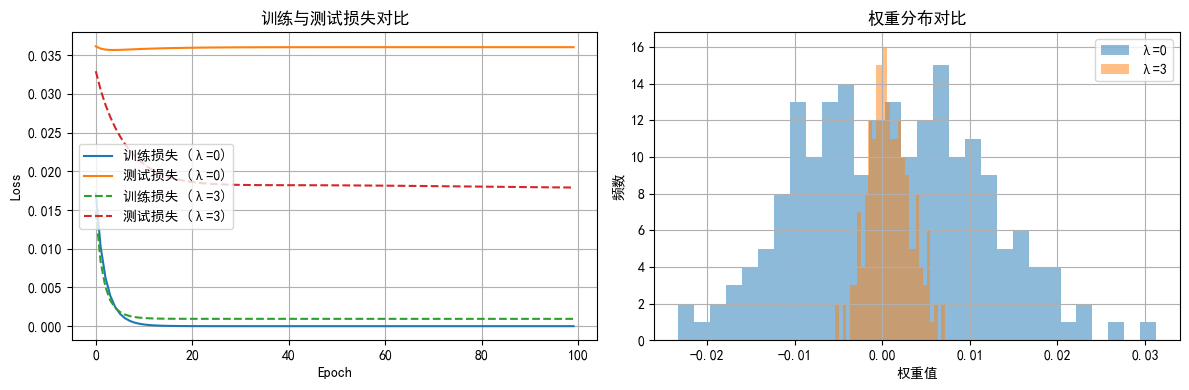

In [23]:
# 可视化对比
plt.figure(figsize=(12, 4))

# 训练和测试损失对比
plt.subplot(1, 2, 1)
plt.plot(train_loss_no_reg, label='训练损失 (λ=0)')
plt.plot(test_loss_no_reg, label='测试损失 (λ=0)')
plt.plot(train_loss_reg, '--', label='训练损失 (λ=3)')
plt.plot(test_loss_reg, '--', label='测试损失 (λ=3)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('训练与测试损失对比')
plt.legend()
plt.grid(True)

# 权重分布对比
plt.subplot(1, 2, 2)
plt.hist(w_no_reg.detach().numpy().flatten(), alpha=0.5, label='λ=0', bins=30)
plt.hist(w_reg.detach().numpy().flatten(), alpha=0.5, label='λ=3', bins=30)
plt.xlabel('权重值')
plt.ylabel('频数')
plt.title('权重分布对比')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# 当然我们还需要用Pytorch再来实现一遍
from torch.utils.data import TensorDataset, DataLoader
def train_with_wd_pytorch(wd=0, lr=0.03, num_epochs=100):
    model = nn.Linear(num_inputs, 1)
    nn.init.normal_(model.weight, mean=0, std=0.01)
    nn.init.zeros_(model.bias)
    
    # 修复1：MSELoss用sum模式 + 除以2，和手动版的mse = mean((y_hat-y)**2)/2 对齐
    # mean((y_hat-y)**2)/2 = sum((y_hat-y)**2)/(2*n) → 等价于 MSELoss(reduction='sum') / (2*n)
    loss_fn = nn.MSELoss(reduction='sum')  

    # 修复2：优化器的学习率除以batch_size，和手动版的w.data -= lr * w.grad / batch_size 对齐
    optimizer = torch.optim.SGD([
        {'params': model.weight, 'weight_decay': wd},
        {'params': model.bias, 'weight_decay': 0}
    ], lr=lr / batch_size)  # 核心：学习率除以batch_size

    train_losses, test_losses = [], []
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for X, y in train_loader:
            optimizer.zero_grad()
            y_pred = model(X)
            # 修复1续：损失除以2*batch_size，和手动版的mse计算完全对齐
            loss = loss_fn(y_pred, y) / (2 * X.shape[0])  
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)  # 平均每个batch的损失
        train_losses.append(train_loss)
        
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for X, y in test_loader:
                y_pred = model(X)
                loss = loss_fn(y_pred, y) / (2 * X.shape[0])
                test_loss += loss.item()
        test_loss /= len(test_loader)
        test_losses.append(test_loss)
        
        if (epoch % 10 == 0):
            print(f'Epoch {epoch+1}, Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}')
            print(f'w的L2范数: {model.weight.norm().item():.6f}')
            
    return model, train_losses, test_losses

# 运行测试
print("\n=== PyTorch实现：不使用权重衰减 ===")
model_no_reg, train_pt_no, test_pt_no = train_with_wd_pytorch(wd=0)

print("\n=== PyTorch实现：使用权重衰减 ===")
model_reg, train_pt_reg, test_pt_reg = train_with_wd_pytorch(wd=3)

train_dataset = TensorDataset(train_X, train_y)
test_dataset = TensorDataset(test_X, test_y)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print("\n=== PyTorch实现：不使用权重衰减 ===")
model_no_reg, train_pt_no, test_pt_no = train_with_wd_pytorch(wd=0)

print("\n=== PyTorch实现：使用权重衰减 ===")
model_reg, train_pt_reg, test_pt_reg = train_with_wd_pytorch(wd=3)



=== PyTorch实现：不使用权重衰减 ===
Epoch 1, Train Loss: 0.014030, Test Loss: 0.016278
w的L2范数: 0.136699
Epoch 11, Train Loss: 0.000068, Test Loss: 0.015858
w的L2范数: 0.139109
Epoch 21, Train Loss: 0.000001, Test Loss: 0.015881
w的L2范数: 0.139443
Epoch 31, Train Loss: 0.000000, Test Loss: 0.015882
w的L2范数: 0.139464
Epoch 41, Train Loss: 0.000000, Test Loss: 0.015882
w的L2范数: 0.139465
Epoch 51, Train Loss: 0.000000, Test Loss: 0.015882
w的L2范数: 0.139465
Epoch 61, Train Loss: 0.000000, Test Loss: 0.015882
w的L2范数: 0.139465
Epoch 71, Train Loss: 0.000000, Test Loss: 0.015882
w的L2范数: 0.139465
Epoch 81, Train Loss: 0.000000, Test Loss: 0.015882
w的L2范数: 0.139465
Epoch 91, Train Loss: 0.000000, Test Loss: 0.015882
w的L2范数: 0.139465

=== PyTorch实现：使用权重衰减 ===
Epoch 1, Train Loss: 0.019483, Test Loss: 0.018748
w的L2范数: 0.125883
Epoch 11, Train Loss: 0.000685, Test Loss: 0.011476
w的L2范数: 0.068773
Epoch 21, Train Loss: 0.000585, Test Loss: 0.009842
w的L2范数: 0.046223
Epoch 31, Train Loss: 0.000563, Test Loss: 0.009383


: 

权重衰减等价于给权重添加高斯先验的贝叶斯推断。
在贝叶斯视角下，模型的权重 θ 不是一个固定的 “最优值”，而是一个服从某种概率分布的随机变量。我们的目标是根据训练数据 D，推断权重 θ 的 “合理分布”。
1. 似然（Likelihood）：P(D|θ)
   - 含义：“给定权重 θ 时，观测到当前训练数据 D 的概率”。
   - 深度学习中，我们常用的损失函数（如 MSE、交叉熵）本质上是对 “负对数似然” 的近似。比如回归任务的 MSE 损失，就是假设标签噪声服从高斯分布时的负对数似然。
   - 最大似然估计（ML）：找到一组权重 θ，让 P(D|θ) 最大，也就是让模型 “最好地拟合训练数据”。
2. 先验（Prior）：P(θ)
   - 含义：“在没看到任何数据前，我们对权重 θ 的‘先验知识’或‘假设’”。
   - 比如 “高斯先验” 就是我们的假设：权重 θ 应该服从均值为 0、方差为 σ² 的高斯分布 N(0, σ²)。
3. 后验（Posterior）：P(θ|D)
   - 含义：“看到训练数据 D 后，权重 θ 的概率分布”—— 这是贝叶斯推断的最终目标。
   - 贝叶斯定理 P(θ|D) = P(D|θ) * P(θ) / P(D)，其中 P(D) 是证据因子，是一个和 θ 无关的常数（可以理解为 “所有可能权重下，观测到数据 D 的总概率”）
最大后验估计（MAP）的目标是：找到一组权重 θ，让后验概率 P(θ|D) 最大。
我们可以对贝叶斯公式取对数忽略常数项 logP(D)，然后得到：
- −logP(D|θ)：最大似然估计（ML）的损失函数（比如 MSE、交叉熵），目标是拟合数据。
- −logP(θ)：L2 正则化项，目标是让权重服从我们的先验假设。
当我们假设权重的先验 P(θ) 是均值为 0 的高斯分布时，−logP(θ) 就是标准的 L2 正则化项。

### 2.4 暂退（Dropout）
Dropout的核心思想：在训练时随机“关闭”一部分神经元，强迫网络不依赖任何单个神经元。
![](/img/pytorch/dropout.png)